# Projeto Final PLN.
# Aluno: Lucas de Almeida Carvalho
# Professor: Emerson Cabrera Paraiso

In [ ]:
#Importação de bibliotecas utilizadas no projeto.
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from operator import itemgetter, attrgetter
import numpy as np
import nltk
import math
nltk.download(['stopwords','rslp','punkt'])
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#De/Para das classes conforme especificação do projeto e criação do novo corpus exportando-o para CSV.
header = ['Sentimento','Texto']
df = pd.read_csv('2000_textos.csv', delimiter=';;',names=header, index_col=False)
df.Sentimento = df.Sentimento.replace('alegria','positivo')
df.Sentimento = df.Sentimento.replace(['raiva','medo','desgosto','tristeza'],'negativo',)
df = df[(df.Sentimento != "surpresa")]
df.Sentimento.unique()
df.to_csv('textos_tratados.csv',encoding='utf-8-sig', index=False, header=False)

In [ ]:
#Definição do classificador SVM
def SVM(features, labels, folds):
  print('SVM (Linear): ')
  parameters = [
      {'C':[10,50,100],'kernel':['linear']},
      {'C':[10,50,100],'kernel':['poly']},
  ]
  clf = svm.SVC(probability=True)
  gs = GridSearchCV(clf, parameters, scoring='accuracy', cv=folds, n_jobs=5)
  gs.fit(features,labels)
  clf = gs.best_estimator_
  table = gs.cv_results_
  print(tabulate(table, headers='keys', tablefmt='psql'))

  print('Best Parameters found')
  print(gs.best_params_)
  
  predict = cross_val_predict(clf, features, labels, cv=folds)
  cm = confusion_matrix(labels, predict)
  print(cm)
  print(classification_report(labels, predict, target_names=np.unique(labels)))
  print('----------------------------------------------')
  return predict, cm

In [ ]:
#Definição do classificador SVM
def SVMwithout_GS(features, labels, folds):
  print('SVM (Linear): ')

  clf = svm.SVC(probability=True, C=50, kernel='linear')
  
  predict = cross_val_predict(clf, features, labels, cv=folds)
  cm = confusion_matrix(labels, predict)
  print(cm)
  print(classification_report(labels, predict, target_names=np.unique(labels)))
  print('----------------------------------------------')
  return predict, cm

In [ ]:
#Definição do classificador KNN
def KNN(features, labels, folds):
  print('KNN: ')
  parameters = [
      {'n_neighbors':[3,5,7],'weights':['uniform','distance']},
      {'algorithm':['ball_tree','kd_tree']},
  ]
  clf = KNeighborsClassifier()
  gs = GridSearchCV(clf, parameters, scoring='accuracy', cv=folds, n_jobs=5)
  gs.fit(features,labels)
  clf = gs.best_estimator_
  table = gs.cv_results_
  print(tabulate(table, headers='keys', tablefmt='psql'))

  print('Best Parameters found')
  print(gs.best_params_)
  
  predict = cross_val_predict(clf, features, labels, cv=folds)
  cm = confusion_matrix(labels, predict)
  print(cm)
  print(classification_report(labels, predict, target_names=np.unique(labels)))
  print('----------------------------------------------')
  return predict, cm

In [ ]:
#Definição do classificador Decision Tree
def Tree(features, labels, folds):
  print('Decision Tree Classifier: ')
  parameters = [
      {'criterion':['gini', 'entropy'],
       'max_depth':[3,5],
       'min_samples_split':[5,10],
       'min_samples_leaf':[5,10]}
  ]
  clf = DecisionTreeClassifier()
  gs = GridSearchCV(clf, parameters, scoring='accuracy', cv=folds, n_jobs=5)
  gs.fit(features,labels)
  clf = gs.best_estimator_
  table = gs.cv_results_
  print(tabulate(table, headers='keys', tablefmt='psql'))

  print('Best Parameters found')
  print(gs.best_params_)
  
  predict = cross_val_predict(clf, features, labels, cv=folds)
  cm = confusion_matrix(labels, predict)
  print(cm)
  print(classification_report(labels, predict, target_names=np.unique(labels)))
  print('----------------------------------------------')
  return predict, cm

In [ ]:
#Definição do classificador Decision Tree
def Tree_without_GS(features, labels, folds):
  print('Decision Tree Classifier: ')
 
  clf = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_leaf=5,min_samples_split=5)
  
  predict = cross_val_predict(clf, features, labels, cv=folds)
  cm = confusion_matrix(labels, predict)
  print(cm)
  print(classification_report(labels, predict, target_names=np.unique(labels)))
  print('----------------------------------------------')
  return predict, cm

In [ ]:
#Pré Processamento dos dados
def loadFile(filename, stopwords, steemer):
  f = open(filename, "r", encoding="utf-8-sig")
  data = []
  while True:
      #lê cada linha do arquivo
      chunk = f.readline()
      #Verificação de final do arquivo 
      if chunk == '': 
          break
      #Divisão em Classe = text[0] Texto = text[1] 
      text = chunk.split(',')
      #Tokenização dos texto
      tokens = nltk.word_tokenize(text[1]) 
      tokensLimpo = []
      #Remoção dos tokens que estão na lista de Stopwords e
      #Aplicação de steemer da palavra.
      for palavra in tokens:
          if (palavra not in stopwords):
              palavra = palavra.lower()
              tokensLimpo.append(stemmer.stem(palavra))
      instance = (text[0], tokensLimpo)
      data.append(instance)
  
  #-------------- BagofWords -------------------
  #Listagem distintas das palavras do corpus
  allwords = []
  for text in data:
      for word in text[1]:
          if word not in allwords:
              allwords.append(word)  
  allwords.sort()

  #Geração da matriz de ocorrências de cada palavra
  qtdPalavras = len(allwords)
  features = []
  labels = []
  for texto in data:
      ocorrencias = []
      labels.append(texto[0])
      for palavra in allwords:
          if palavra in texto[1]:
              ocorrencias.append(texto[1].count(palavra))
          else:
              ocorrencias.append(0)
      features.append(ocorrencias)

  return labels, features, allwords

In [ ]:
#Lista StopWords
stopwords = nltk.corpus.stopwords.words('portuguese') #Stopwords da lingua portuguesa
stopwords+= (',','.','(',')','"',"'",'´','`','!','$','%','&','...','-',':',';','?','``','\'\'') #acrescenta simbolos
stopwords+= ('a','e','i','o','u','A','E','I','O','U') #acrescenta vogais
stemmer = nltk.stem.RSLPStemmer()

InputFile = "textos_tratados.csv"

labels3, features3, allwords3 = loadFile(InputFile, stopwords, stemmer)

In [ ]:
#Fit de modelo usando SVM Pré Balanceamento dos dados
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3)))
print("Features 3 classes: "+str(len(features3[0])))

# Tempo total aprox: 1h15Min
predict3, cm3 = SVM(features3, labels3, 10)

----------------------------------------------
Instâncias 3 classes: 1748
Features 3 classes: 4783
SVM (Linear): 
+-----------------+----------------+-------------------+------------------+-----------+----------------+--------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time |   param_C | param_kernel   | params                         |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   split5_test_score |   split6_test_score |   split7_test_score |   split8_test_score |   split9_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|-----------------+----------------+----------------

In [ ]:
#Fit do modelo usando KNN Pré Balanceamento dos dados
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3)))
print("Features 3 classes: "+str(len(features3[0])))

# Tempo total aprox: 25min
predict3, cm3 = KNN(features3, labels3, 10)

----------------------------------------------
Instâncias 3 classes: 1748
Features 3 classes: 4783
KNN: 


/usr/local/lib/python3.7/dist-packages/tabulate.py:634: UserWarning: Warning: converting a masked element to nan.
  conv(string)
/usr/local/lib/python3.7/dist-packages/tabulate.py:1037: UserWarning: Warning: converting a masked element to nan.
  return format(float(val), floatfmt)


+-----------------+----------------+-------------------+------------------+---------------------+-----------------+-------------------+-------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time |   param_n_neighbors | param_weights   | param_algorithm   | params                                    |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   split5_test_score |   split6_test_score |   split7_test_score |   split8_test_score |   split9_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|-----------------+----------------+-------------------+------------------+-------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Fit do modelo usando Decision Tree Pré Balanceamento dos dados
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3)))
print("Features 3 classes: "+str(len(features3[0])))

# Tempo total aprox: 25min
predict3, cm3 = Tree(features3, labels3, 10)

----------------------------------------------
Instâncias 3 classes: 1748
Features 3 classes: 4783
Decision Tree Classifier: 
+-----------------+----------------+-------------------+------------------+-------------------+-------------------+--------------------------+---------------------------+-------------------------------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_criterion   |   param_max_depth |   param_min_samples_leaf |   param_min_samples_split | params                                                                                    |   split0_test_score |   split1_test_score |   split2_test_score |   s

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


positivo    1022
negativo    1022
neutro      1022
dtype: int64


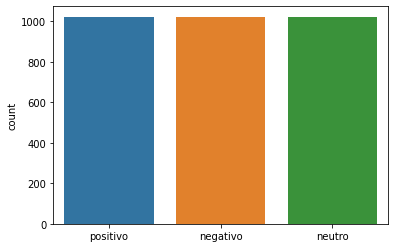

In [ ]:
#Estratégia de balanceamento dos dados usanto SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE
smote = SMOTE(random_state = 32)
features3_over, labels3_over = smote.fit_resample(features3, labels3)
print(pd.Series(labels3_over).value_counts())
sns.countplot(labels3_over);

positivo    1022
negativo    1022
neutro      1022
dtype: int64


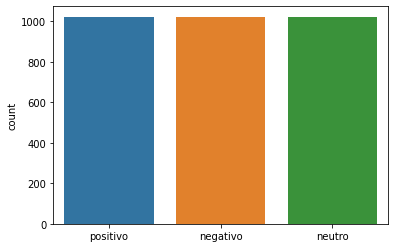

In [ ]:
#Aplicação de balanceamento dos dados usando método RandomOverSampler

over = RandomOverSampler()
features3_over, labels3_over = over.fit_resample(features3, labels3)

#Validação da nova distribuição dos dados balanceados.
print(pd.Series(labels3_over).value_counts())
sns.countplot(labels3_over);

In [ ]:
#Fit de modelo usando SVM com os dados balanceados.
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3_over)))
print("Features 3 classes: "+str(len(features3_over[0])))

# Tempo total aprox: 1h15Min
predict3, cm3 = SVMwithout_GS(features3_over, labels3_over, 10)

----------------------------------------------
Instâncias 3 classes: 3066
Features 3 classes: 4783
SVM (Linear): 
[[782 122 118]
 [163 388 471]
 [ 65  49 908]]
              precision    recall  f1-score   support

    negativo       0.77      0.77      0.77      1022
      neutro       0.69      0.38      0.49      1022
    positivo       0.61      0.89      0.72      1022

    accuracy                           0.68      3066
   macro avg       0.69      0.68      0.66      3066
weighted avg       0.69      0.68      0.66      3066

----------------------------------------------


In [ ]:
#Fit de modelo usando SVM com os dados balanceados.
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3_over)))
print("Features 3 classes: "+str(len(features3_over[0])))

# Tempo total aprox: 1h15Min
predict3, cm3 = SVMwithout_GS(features3_over, labels3_over, 10)

----------------------------------------------
Instâncias 3 classes: 3066
Features 3 classes: 4783
SVM (Linear): 
[[ 821  153   48]
 [  65  932   25]
 [   0    1 1021]]
              precision    recall  f1-score   support

    negativo       0.93      0.80      0.86      1022
      neutro       0.86      0.91      0.88      1022
    positivo       0.93      1.00      0.97      1022

    accuracy                           0.90      3066
   macro avg       0.91      0.90      0.90      3066
weighted avg       0.91      0.90      0.90      3066

----------------------------------------------


In [ ]:
#Fit do modelo usando KNN com os dados balanceados.
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3_over)))
print("Features 3 classes: "+str(len(features3_over[0])))

# Tempo total aprox: 40min
predict3, cm3 = KNN(features3_over, labels3_over, 10)

In [ ]:
#Fit do modelo usando Decision Tree com os dados balanceados.
print('----------------------------------------------') 
print("Instâncias 3 classes: "+str(len(labels3_over)))
print("Features 3 classes: "+str(len(features3_over[0])))

# Tempo total aprox: 1min
predict3, cm3 = Tree_without_GS(features3_over, labels3_over, 10)

----------------------------------------------
Instâncias 3 classes: 3066
Features 3 classes: 4783
Decision Tree Classifier: 
[[305  89 628]
 [ 15 195 812]
 [  7 102 913]]
              precision    recall  f1-score   support

    negativo       0.93      0.30      0.45      1022
      neutro       0.51      0.19      0.28      1022
    positivo       0.39      0.89      0.54      1022

    accuracy                           0.46      3066
   macro avg       0.61      0.46      0.42      3066
weighted avg       0.61      0.46      0.42      3066

----------------------------------------------
